In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import fit, norm, chisquare, goodness_of_fit, lognorm, t,beta, cosine, uniform
from scipy.optimize import curve_fit
from tqdm import tqdm

# Creating the master dataframe

lengthdf = pd.read_csv('..\\Search Area Results\\iteration_1_raw.csv') # we just need this for the length


count = 0
n_bins=10
bin_size = int(len(lengthdf)/n_bins)



rdgprobs = pd.DataFrame()
allprobs = pd.DataFrame(np.array([np.zeros(len(lengthdf))]).T,columns=['CLASS'])
allprobs['sum']=np.zeros(len(allprobs))

# We want to add results from each iteration to a master dataframe

for i in range(1,11):
    df = pd.read_csv('..\\Search Area Results\\iteration_'+str(i)+'_raw.csv')
    rdgprobs['iteration_' +str(i)] = df.loc[df['CLASS1']==3]['y_probs_bll']
    allprobs['iteration_'+str(i)] = df['y_probs_bll']
    allprobs['CLASS_it' +str(i) ]=df['CLASS1']


Freedman-Diaconis' Rule for histogram bin widths is implemented below

In [62]:
# extracting key features of the data e.g. interquartile range

IQR = np.zeros(10)
for i in range(1,11):
    IQR[i-1] = allprobs['iteration_'+str(i)].quantile(q=0.75)-allprobs['iteration_'+str(i)].quantile(q=0.25)

IQR_av = np.average(IQR)

# extracting the number of radio galaxies

n = len(rdgprobs)

# implementing freedman-diaconis

h = 2*IQR_av*(n**(-1/3))

print(h) 



0.40559230998585855


Plotting a Histogram based on Freedman-Diaconis

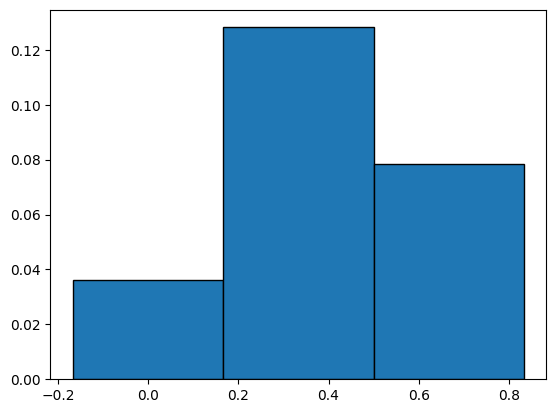

In [70]:
n_bins = int(np.ceil(1/h))

bin_width = 1/n_bins

# averaging columns

probs_asc = pd.DataFrame()

for i in range(1,11):
    probs_asc['it'+str(i)] = np.sort(np.array(allprobs['iteration_'+str(i)]))

probs_avgs = probs_asc.mean(axis=1)

# averaging radio galaxy probs (radio galaxies are always in the same order)
rdgprobs_avgs = np.array(rdgprobs.mean(axis=1))

# binning the data

freedman_bins = pd.DataFrame(np.array([np.arange(0,n_bins,1),np.zeros(n_bins),np.zeros(n_bins)]).T,columns=('bin','total count','rdg count'))

for i in range(0,n_bins):
    for k in range(0,len(allprobs)):
        if probs_avgs[k] >= bin_width*i and probs_avgs[k] < bin_width*(i+1):
            freedman_bins['total count'][i] +=1
    for k in range(0,len(rdgprobs_avgs)):
        if rdgprobs_avgs[k] >= bin_width*i and rdgprobs_avgs[k] < bin_width*(i+1):
            freedman_bins['rdg count'][i] +=1
        

freedman_bins['rdg frac'] = freedman_bins['rdg count']/freedman_bins['total count']
plt.bar(freedman_bins['bin']/n_bins,freedman_bins['rdg frac'],width = bin_width,edgecolor='black')

freedman_bins['bin median'] = (bin_width * freedman_bins['bin']) + 0.5*bin_width

In [115]:
# In order to create dummy data we must create data which is distributed across the bins in the same proportions
# and yet has an overall sample size equal to the overall number of radio galaxies

def bin_rounding(xs,n_bins):
    bin_width = 1/n_bins
    bins = np.arange(0,n_bins,1)
    bin_medians = (bin_width*bins)+0.5*bin_width
    roundedxs = np.empty(len(xs))

    for i in range(0,n_bins):
        for k in range(0,len(xs)):
            if xs[k] >= bin_width*i and xs[k] < bin_width*(i+1):
                roundedxs[k] = bin_medians[i]

    return roundedxs

freedman_bins['adjusted rdg count'] = ((freedman_bins['rdg frac']/(freedman_bins['rdg frac'].sum()))*freedman_bins['rdg count'].sum()).round()
dummydata = np.array([])

for i in range(0,len(freedman_bins)):
    dummydata = np.append(dummydata,freedman_bins['bin median'][i]*np.ones(int(freedman_bins['adjusted rdg count'][i])))


# in order to do a parametric bootstrap test we will generate values (monte carlo method) according to the test
# distribution, then ROUND THEM (so that they have median bin values) and then compare the K-S statistic of the rounded 
# values to the K-S statistic of the original distribution

fitresults = goodness_of_fit(norm,dummydata,statistic='ks',n_mc_samples=5)
fitresultsdf=pd.DataFrame([[fitresults[0],fitresults[1],fitresults[2]]],columns=['Fit Results','KS Statistic','P-Value'])
#fitresultsdf.to_csv('fit_results_normal_(freedman)_'+str(iteration)+'.csv')
#print(fitresults)

# generating values

mc_norm = norm.rvs(size=99999,loc=0.556,scale=0.224)
mc_norm = [x for x in mc_norm if x<1]
mc_norm = [x for x in mc_norm if x>0]
mc_norm_binned = bin_rounding(mc_norm,3)

mc_norm_binned = mc_norm_binned[:53]
print(len(mc_norm_binned))
print(np.unique(mc_norm_binned))





53
[0.16666667 0.5        0.83333333]


In [65]:
'''
y_probs=np.empty(len(allprobs))

for iteration in tqdm(range(1,2)):
    y_probs=allprobs['iteration_'+str(iteration)]
    classes=allprobs['CLASS_it' +str(iteration)]

    y_probs_ascending=np.sort(y_probs)
    y_probs_descending=np.flip(y_probs_ascending)


    cutoff_prob_a = np.array([0])
    cutoff_prob_d = np.array([1])
    #print(y_probs_ascending)

    for i in range(0,len(y_probs)):
        count+=1
        if count >= bin_size:
            cutoff_prob_a = np.append(cutoff_prob_a,y_probs_ascending[i])
            cutoff_prob_d = np.append(cutoff_prob_d,y_probs_descending[i])
            count = 0
    n_bins = len(cutoff_prob_a)-1

    bins = pd.DataFrame((np.array([y_probs,classes,np.zeros(len(classes)),np.zeros(len(classes))]).T),
                        columns=['y_probs','classes','bin_n_ascending','bin_n_descending'])

    for i in range(0,n_bins):
        for k in range(0,len(y_probs)):
            if y_probs[k] >= cutoff_prob_a[i] and y_probs[k] < cutoff_prob_a[i+1]:
                bins['bin_n_ascending'][k] = i
            if y_probs[k] <= cutoff_prob_d[i] and y_probs[k] > cutoff_prob_d[i+1]:
                bins['bin_n_descending'][k] = i

    lowerbounds = np.delete(cutoff_prob_a,-1)
    upperbounds = np.delete(cutoff_prob_a,0)
    totals_asc = pd.DataFrame((np.array([np.zeros(n_bins),lowerbounds, upperbounds,np.zeros(n_bins),np.zeros(n_bins),np.zeros(n_bins)]).T),
                                    columns=['Bin (asc)','Lower Bound','Upper Bound','RDG Count','Total Count','Frac'])


    for i in range(0,n_bins): # iterates over each bin in the set
            n_rdg = bins.loc[(bins['bin_n_ascending']==i) & (bins['classes']==3)]
            n_bll = bins.loc[(bins['bin_n_ascending']==i) & (bins['classes']==0)]
            n_fsrq = bins.loc[(bins['bin_n_ascending']==i) & (bins['classes']==1)]
            tot = len(n_rdg)+len(n_bll)+len(n_fsrq)
            #print(f'n_rdg is {len(n_rdg)} from {tot} in ascending bin {i}')
            totals_asc['Bin (asc)'][i] = i
            totals_asc['RDG Count'][i] = len(n_rdg)
            totals_asc['Total Count'][i] = tot
            totals_asc['Frac'][i] = len(n_rdg)/tot

    #totals_asc.to_csv('..\\Search Area Results\\iteration_10')
    #fig, ax = plt.subplots()
    #ax.bar(totals_asc['Bin (asc)'],totals_asc['RDG Count'])
    #ax.set_xlabel('Bin Number')
    #ax.set_ylabel('Fraction of Radio Galaxies')
    totals_asc.to_csv('totals_asc'+str(iteration)+'.csv')


    dummydata = np.array([])

    for i in range(0,len(totals_asc)):
        dummydata = np.append(dummydata,totals_asc['Bin (asc)'][i]*np.ones(int(totals_asc['RDG Count'][i])))

    fittype=beta
    xs = np.arange(0,len(totals_asc),1)
    
    guess = list(beta.fit(dummydata))
    
    fitresults = goodness_of_fit(norm,dummydata,statistic='ks',n_mc_samples=999,guessed_params={'a':guess[0],'b':guess[1],'scale':guess[3]})
    fitresultsdf=pd.DataFrame([[fitresults[0],fitresults[1],fitresults[2]]],columns=['Fit Results','KS Statistic','P-Value'])
    fitresultsdf.to_csv('fit_results_normal_'+str(iteration)+'.csv')
'''


"\ny_probs=np.empty(len(allprobs))\n\nfor iteration in tqdm(range(1,2)):\n    y_probs=allprobs['iteration_'+str(iteration)]\n    classes=allprobs['CLASS_it' +str(iteration)]\n\n    y_probs_ascending=np.sort(y_probs)\n    y_probs_descending=np.flip(y_probs_ascending)\n\n\n    cutoff_prob_a = np.array([0])\n    cutoff_prob_d = np.array([1])\n    #print(y_probs_ascending)\n\n    for i in range(0,len(y_probs)):\n        count+=1\n        if count >= bin_size:\n            cutoff_prob_a = np.append(cutoff_prob_a,y_probs_ascending[i])\n            cutoff_prob_d = np.append(cutoff_prob_d,y_probs_descending[i])\n            count = 0\n    n_bins = len(cutoff_prob_a)-1\n\n    bins = pd.DataFrame((np.array([y_probs,classes,np.zeros(len(classes)),np.zeros(len(classes))]).T),\n                        columns=['y_probs','classes','bin_n_ascending','bin_n_descending'])\n\n    for i in range(0,n_bins):\n        for k in range(0,len(y_probs)):\n            if y_probs[k] >= cutoff_prob_a[i] and y_probs

[]


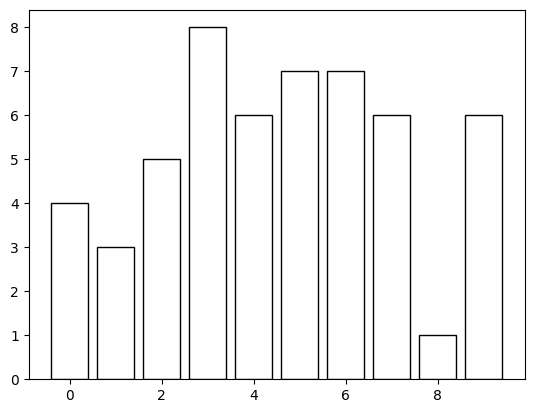

In [66]:
plt.bar(totals_asc['Bin (asc)'],totals_asc['RDG Count'],color='white',edgecolor='black')
print(dummydata)